# Solving 3-D Magneto-Coriolis Eigenproblems

The initial import in Jupyter notebook seems to be slightly laggy. This is probably due to loading of the quicc package or just-in-time compilation?

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import models
from operators import polynomials as poly
import utils, pgpy_utils, tools, h5py

The first part of this notebook aims to reproduce the results from [Waves in the Earth's core II. Magneto-Coriolis modes](https://doi.org/10.1098/rspa.2022.0108).

---
## Toroidal quadrupolar field

*T1* field in the paper. 

$$
\mathbf{B}_0 = \nabla \times \left(\gamma r(1 - r^2) Y_1^0(\theta, \phi) \mathbf{r}\right) = \gamma r(1 - r^2) \sin\theta \hat{\phi}
$$

In [2]:
E_eta = 1e-4
Elsasser = 1.
m_val = 1
bg_modes = [poly.SphericalHarmonicMode("tor", 1, 0, "(3 Sqrt[3]/2) r(1 - r^2)")]
mod_setup_MC = models.MagnetoCoriolis

Compute eigenvalue spectrum

In [71]:
tools.print_heading(f"Calculating eigen spectrum for m = {m_val}, E_eta = {E_eta:.2e}, Elsasser = {Elsasser: .2e}", 
                    prefix='\n', suffix='\n', lines="over", char='=')

resolutions = [
    (31, 31, m_val),
    (41, 41, m_val)
]
# spectra = list()
spectra_QP = list()
spectra_DP = list()

for i_res, res in enumerate(resolutions):
    
    nr, maxnl, m = res
    tools.print_heading(f"Resolution (L, N)=({maxnl}, {nr})", prefix='\n', suffix='\n', lines="over", char='-')
    
    with utils.Timer("Build operator"):
        
        mod = mod_setup_MC(
            nr, maxnl, m, inviscid=True,
            induction_eq_params={'galerkin': True, 'ideal': False, 'boundary_condition': True}
        )
        # A, B = mod.setup_operator(
        #     field_modes=bg_modes, setup_eigen=True, magnetic_ekman=E_eta, elsasser=Elsasser
        # )
        op_dp, op_qp = mod.setup_operator(
            field_modes=bg_modes, setup_eigen=True, magnetic_ekman=E_eta, elsasser=Elsasser, 
            parity=True, u_parity="same"
        )
    
    # print(f"K shape: {A.shape[0]}x{A.shape[1]}\n"
    #       f"M shape: {B.shape[0]}x{B.shape[1]}")  
    # with utils.Timer("Solve eigensystem"):
    #     w = utils.full_spectrum(A, B)
    # spectra.append(w)
    # del A, B
    
    print(f"DP system: {op_dp[0].shape[0]}x{op_dp[0].shape[1]}")
    with utils.Timer("Solve DP eigensystem"):
        w = utils.full_spectrum(op_dp[0], op_dp[1])
    spectra_DP.append(w)
    
    print(f"QP system: {op_qp[0].shape[0]}x{op_qp[0].shape[1]}")
    with utils.Timer("Solve QP eigensystem"):
        w = utils.full_spectrum(op_qp[0], op_qp[1])
    spectra_QP.append(w)


Calculating eigen spectrum for m = 1, E_eta = 1.00e-04, Elsasser =  1.00e+00


----------------------------------------------------------------
Resolution (L, N)=(31, 31)

Build operator elapsed 3.31 s.
DP system: 1830x1830
Solve DP eigensystem elapsed 98.01 s.
QP system: 1830x1830
Solve DP eigensystem elapsed 92.88 s.

----------------------------------------------------------------
Resolution (L, N)=(41, 41)

Build operator elapsed 7.53 s.
DP system: 3240x3240
Solve DP eigensystem elapsed 426.41 s.
QP system: 3240x3240
Solve DP eigensystem elapsed 420.93 s.


Sort according to their imaginary parts:

In [22]:
for i_w, w in enumerate(spectra):
    sort_idx = np.argsort(np.imag(w))
    spectra[i_w] = w[sort_idx]

### Inspect spectrum

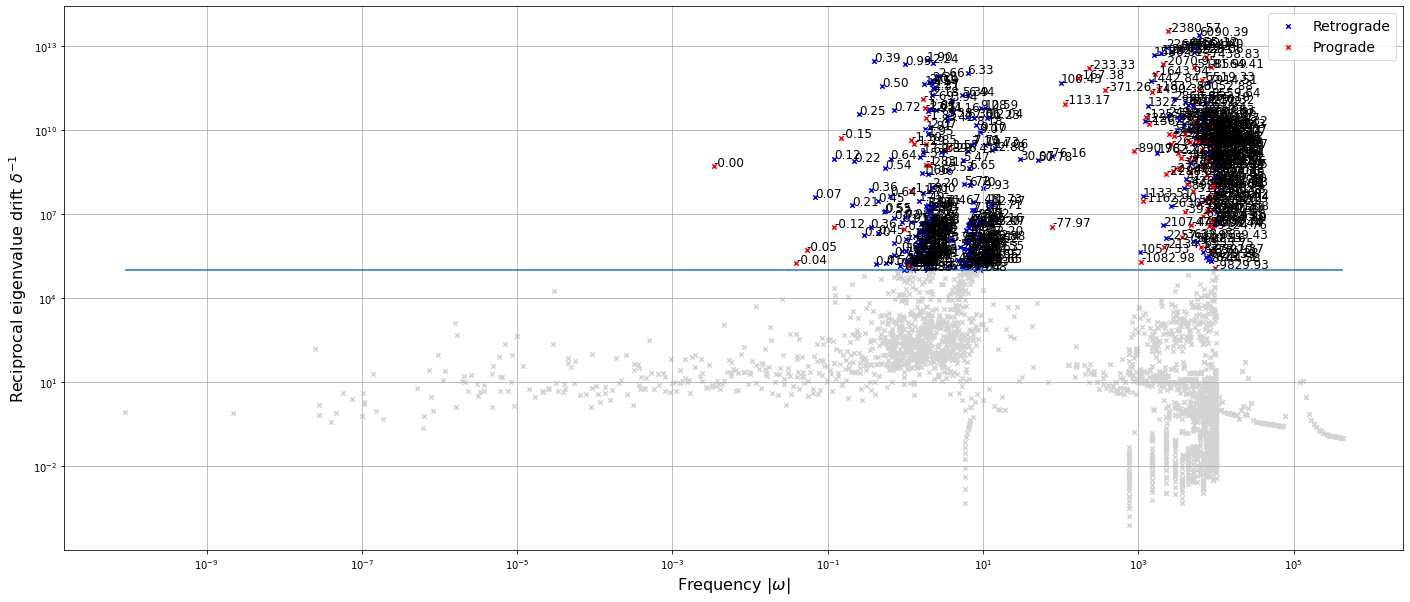

In [23]:
eig_base, eig_comp = spectra[2], spectra[1]
drift, nearest_idx = pgpy_utils.eigen_drift(eig_base, eig_comp)

fig, ax = plt.subplots(figsize=(24, 10))

threshold = 1e+5
reciproc = 1./drift
idx = np.arange(drift.size)

# ax.scatter(idx[reciproc > threshold], reciproc[reciproc > threshold], 20, color='b', marker='x')
# ax.scatter(idx[reciproc <= threshold], reciproc[reciproc <= threshold], 20, color='k', marker='x')
# for idx_tmp in idx[reciproc > threshold]:
#     ax.annotate("{:.2f}".format(eig_vals[1][idx_tmp]), (idx_tmp, reciproc[idx_tmp]))
# ax.hlines([threshold,], idx[0] - 1, idx[-1] + 1)
# ax.set_xlim([idx[0] - 1, idx[-1] + 1])

idx_pos = eig_base.imag >= 0
idx_neg = eig_base.imag < 0

ax.scatter(np.abs(eig_base[(reciproc > threshold) & idx_pos].imag), reciproc[(reciproc > threshold) & idx_pos], 20, color='b', marker='x', label="Retrograde")
ax.scatter(np.abs(eig_base[(reciproc > threshold) & idx_neg].imag), reciproc[(reciproc > threshold) & idx_neg], 20, color='r', marker='x', label="Prograde")
ax.scatter(np.abs(eig_base[reciproc <= threshold].imag), reciproc[reciproc <= threshold], 20, color='lightgray', marker='x')
for idx_tmp in idx[reciproc > threshold]:
    ax.annotate("{:.2f}".format(eig_base[idx_tmp].imag), (np.abs(eig_base[idx_tmp].imag), reciproc[idx_tmp]), fontsize=12)
ax.hlines([threshold,], np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max())
ax.legend(fontsize=14)

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max()])
# ax.set_xlim([10, np.abs(eig_base.imag).max()])
ax.set_xlabel(r"Frequency $|\omega|$", fontsize=16)
ax.set_ylabel(r"Reciprocal eigenvalue drift $\delta^{-1}$", fontsize=16)
ax.grid(which="both")

plt.show()

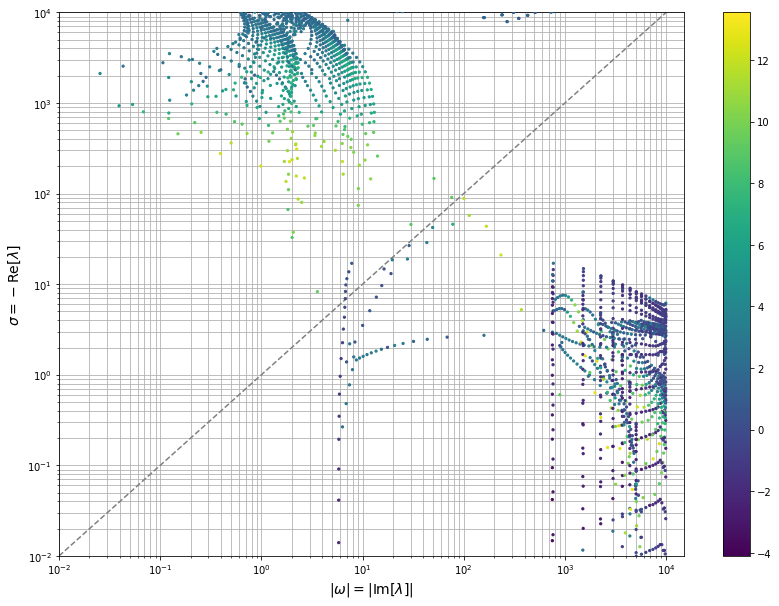

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10))

im = ax.scatter(np.abs(np.imag(eig_base)), -np.real(eig_base), s=5, c=np.log10(reciproc), zorder=5)
plt.colorbar(im, ax=ax)

ax.plot([1e-2, 1e+4], [1e-2, 1e+4], '--', color="gray")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-2, 1.5e+4])
ax.set_ylim([1e-2, 1e+4])
ax.set_xlabel(r"$|\omega| = |\mathrm{Im}[\lambda]|$", fontsize=14)
ax.set_ylabel(r"$\sigma = -\mathrm{Re}[\lambda]$", fontsize=14)
ax.grid(which="both")

plt.show()

Output

In [14]:
import h5py

with h5py.File("./out/T1__eigenspec_m1__E_eta_1e-4.h5", 'x') as fwrite:
    for i_res, res in enumerate(resolutions):
        gp = fwrite.create_group(f"eigenspec_res{i_res}")
        gp.attrs["L"] = res[0]
        gp.attrs["N"] = res[1]
        gp.attrs["m"] = res[2]
        gp.create_dataset("spectrum", data=spectra[i_res])

In [80]:
import h5py

with h5py.File("./out/T1__eigenspec_m1__E_eta_1e-4__same_parities.h5", 'x') as fwrite:
    for i_res, res in enumerate(resolutions):
        gp = fwrite.create_group(f"eigenspec_res{i_res}")
        gp.attrs["L"] = res[0]
        gp.attrs["N"] = res[1]
        gp.attrs["m"] = res[2]
        ds = gp.create_dataset("spectrum_DP", data=spectra_DP[i_res])
        ds.attrs["u_parity"] = "same"
        ds = gp.create_dataset("spectrum_QP", data=spectra_QP[i_res])
        ds.attrs["u_parity"] = "same"

Filtering

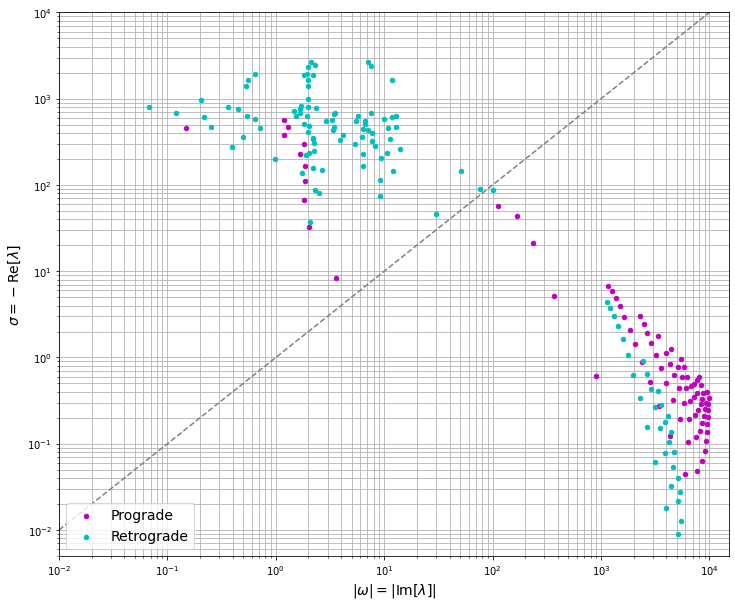

In [25]:
threshold = 1e+7
converge_filter = reciproc > threshold

spectrum_converged = eig_base[converge_filter]

classify_list = [
    [lambda x: x.imag < -1e-7, {"s": 20, "marker": 'o', "color": "m", "label": "Prograde"}],
    [lambda x: x.imag > +1e-7, {"s": 20, "marker": 'o', "color": "c", "label": "Retrograde"}]
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))

for classifier in classify_list:
    class_idx = classifier[0](spectrum_converged)
    ax.scatter(np.abs(np.imag(spectrum_converged[class_idx])), -np.real(spectrum_converged[class_idx]), **classifier[1], zorder=5)

ax.plot([1e-2, 1e+4], [1e-2, 1e+4], '--', color="gray")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-2, 1.5e+4])
ax.set_ylim([0.5e-2, 1e+4])
ax.set_xlabel(r"$|\omega| = |\mathrm{Im}[\lambda]|$", fontsize=14)
ax.set_ylabel(r"$\sigma = -\mathrm{Re}[\lambda]$", fontsize=14)
ax.grid(which="both")
ax.legend(fontsize=14, loc=3)

plt.show()

---
## Ideal eigenproblem

In [2]:
Le = np.sqrt(2)*1e-4
m_val = 3
mod_setup_MC = models.IdealMagnetoCoriolis

In [3]:
tools.print_heading(f"Calculating eigen spectrum for m = {m_val}, Le = {Le:.3e}", prefix='\n', suffix='\n', lines="over", char='=')

resolutions = [
    (11, 11, m_val),
    (21, 21, m_val),
    (31, 31, m_val)
]
eig_vals = list()
eig_vecs = list()

for i_res, res in enumerate(resolutions):
    
    nr, maxnl, m = res
    tools.print_heading(f"Resolution (L, N)=({maxnl}, {nr})", prefix='\n', suffix='\n', lines="over", char='-')
    
    with utils.Timer("Build operator"):
        
        bg_modes = [poly.SphericalHarmonicMode("pol", 1, 0, "r(3r^2 - 5)")]
        mod = mod_setup_MC(nr, maxnl, m)
        A, B = mod.setup_operator(
            field_modes=bg_modes, setup_eigen=True, lehnert=Le,
        )
    
    print(f"K shape: {A.shape[0]}x{A.shape[1]}\n"
          f"M shape: {B.shape[0]}x{B.shape[1]}")
    
    with utils.Timer("Solve eigensystem"):
        w = utils.full_spectrum(A, B)
    eig_vals.append(w)
    del A, B
    # w, v = single_eig(op_dp, op_qp, target=-337.j, nev=1)
    # print(w)


Calculating eigen spectrum for m = 3, Le = 1.414e-04


----------------------------------------------------------------
Resolution (L, N)=(11, 11)

Build operator elapsed 0.66 s.
K shape: 336x336
M shape: 336x336
Solve eigensystem elapsed 0.13 s.

----------------------------------------------------------------
Resolution (L, N)=(21, 21)

Build operator elapsed 1.02 s.
K shape: 1476x1476
M shape: 1476x1476
Solve eigensystem elapsed 22.70 s.

----------------------------------------------------------------
Resolution (L, N)=(31, 31)

Build operator elapsed 1.83 s.
K shape: 3416x3416
M shape: 3416x3416
Solve eigensystem elapsed 294.88 s.


Sort according to their imaginary parts:

In [4]:
for i_w, w in enumerate(eig_vals):
    sort_idx = np.argsort(np.imag(w))
    eig_vals[i_w] = w[sort_idx]

### Inspect spectrum

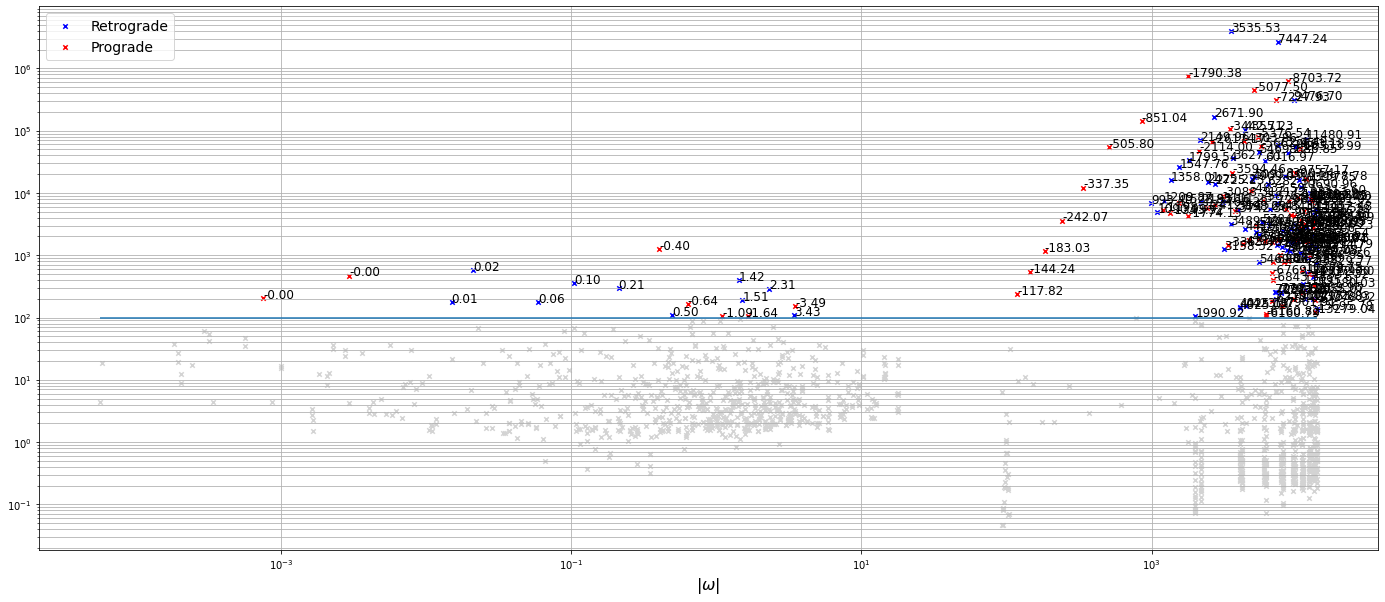

In [13]:
eig_base, eig_comp = eig_vals[1], eig_vals[2]
drift, nearest_idx = pgpy_utils.eigen_drift(eig_base, eig_comp)

fig, ax = plt.subplots(figsize=(24, 10))

threshold = 1e+2
reciproc = 1./drift
idx = np.arange(drift.size)

# ax.scatter(idx[reciproc > threshold], reciproc[reciproc > threshold], 20, color='b', marker='x')
# ax.scatter(idx[reciproc <= threshold], reciproc[reciproc <= threshold], 20, color='k', marker='x')
# for idx_tmp in idx[reciproc > threshold]:
#     ax.annotate("{:.2f}".format(eig_vals[1][idx_tmp]), (idx_tmp, reciproc[idx_tmp]))
# ax.hlines([threshold,], idx[0] - 1, idx[-1] + 1)
# ax.set_xlim([idx[0] - 1, idx[-1] + 1])

idx_pos = eig_base.imag >= 0
idx_neg = eig_base.imag < 0

ax.scatter(np.abs(eig_base[(reciproc > threshold) & idx_pos].imag), reciproc[(reciproc > threshold) & idx_pos], 20, color='b', marker='x', label="Retrograde")
ax.scatter(np.abs(eig_base[(reciproc > threshold) & idx_neg].imag), reciproc[(reciproc > threshold) & idx_neg], 20, color='r', marker='x', label="Prograde")
ax.scatter(np.abs(eig_base[reciproc <= threshold].imag), reciproc[reciproc <= threshold], 20, color='lightgray', marker='x')
for idx_tmp in idx[reciproc > threshold]:
    ax.annotate("{:.2f}".format(eig_base[idx_tmp].imag), (np.abs(eig_base[idx_tmp].imag), reciproc[idx_tmp]), fontsize=12)
ax.hlines([threshold,], np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max())
ax.legend(fontsize=14)

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max()])
# ax.set_xlim([10, np.abs(eig_base.imag).max()])
ax.set_xlabel(r"$|\omega|$", fontsize=16)
ax.grid(which="both")

plt.show()

Output

In [19]:
import h5py

with h5py.File("./out/S1_ideal__eigenspec_m3.h5", 'x') as fwrite:
    for i_res, res in enumerate(resolutions):
        gp = fwrite.create_group(f"eigenspec_res{i_res}")
        gp.attrs["L"] = res[0]
        gp.attrs["N"] = res[1]
        gp.attrs["m"] = res[2]
        gp.create_dataset("spectrum", data=eig_vals[i_res])

---
### Calculate eigenmodes for selected eigenvalues

Can we really afford to calculate all eigenvectors corresponding to the full spectrum? (Also is it necessary?)

In [3]:
tools.print_heading(f"Calculating selected eigenmodes for m = {m_val}, Le = {Le:.3e}", prefix='\n', suffix='\n', lines="over", char='=')

res = (51, 51, m_val)
nr, maxnl, m = res
print(f"Resolution (L, N)=({maxnl}, {nr})")

eig_targets = [
    -1790.j,
    -851.j,
    -506.j,
    -337.j,
    -241.j,
    -182.j,
    -142.j,
    +3535.j
]
eig_vals_selected = list()
eig_vecs_selected = list()

with utils.Timer("Build operator"):

    bg_modes = [poly.SphericalHarmonicMode("pol", 1, 0, "r(3r^2 - 5)")]
    mod = mod_setup_MC(nr, maxnl, m)
    A, B = mod.setup_operator(
        field_modes=bg_modes, setup_eigen=True, lehnert=Le
    )

print(f"K shape: {A.shape[0]}x{A.shape[1]}\n"
      f"M shape: {B.shape[0]}x{B.shape[1]}")


for i_target, target in enumerate(eig_targets):
    with utils.Timer(f"Calculating near lambda={target}"):
        w, v = utils.single_eig(A, B, target, nev=1)
    eig_vals_selected.append(w)
    eig_vecs_selected.append(v)

del A, B


Calculating selected eigenmodes for m = 3, Le = 1.414e-04

Resolution (L, N)=(51, 51)
Build operator elapsed 7.25 s.
K shape: 9696x9696
M shape: 9696x9696
Calculating near lambda=(-0-1790j) elapsed 0.72 s.
Calculating near lambda=(-0-851j) elapsed 0.60 s.
Calculating near lambda=(-0-506j) elapsed 0.59 s.
Calculating near lambda=(-0-337j) elapsed 0.59 s.
Calculating near lambda=(-0-241j) elapsed 0.59 s.
Calculating near lambda=(-0-182j) elapsed 0.58 s.
Calculating near lambda=(-0-142j) elapsed 0.60 s.
Calculating near lambda=3535j elapsed 0.58 s.


In [4]:
eig_vals_selected

[array([-5.41623099e-14-1790.38241107j]),
 array([-5.47869359e-16-851.04596179j]),
 array([5.08283225e-15-505.80402095j]),
 array([-1.04203116e-13-337.36807074j]),
 array([2.02013547e-13-242.1061898j]),
 array([-4.91086584e-13-183.10372479j]),
 array([1.01405751e-12-144.36031772j]),
 array([4.08090904e-15+3535.53174286j])]

---
## Eigenmodes

In [2]:
import models
from operators.polynomials import SphericalHarmonicMode
from operators.worland_transform import WorlandTransform
from operators.associated_legendre_transform import AssociatedLegendreTransformSingleM
from fields import VectorFieldSingleM

nr, maxnl, m_val = 63, 63, 3

model = models.MagnetoCoriolis_Alfven(nr, maxnl, m_val, inviscid=True,
    induction_eq_params={'galerkin': False, 'ideal': False, 'boundary_condition': True})

### Calculate on the fly

Construct left and right matrix operator:

In [241]:
# S1 background field
# bg_modes = [SphericalHarmonicMode("pol", 1, 0, "1/5 Sqrt[pi/3] r(5-3r^2)")]
# bg_modes = [SphericalHarmonicMode("pol", 1, 0, "2 Sqrt[pi/3] r(3r^2 - 5)")]

# S2 background field
# bg_modes = [SphericalHarmonicMode("pol", 2, 0, "5/14 Sqrt[3/182] r^2(157 - 296r^2 + 143r^4)")]
bg_modes = [SphericalHarmonicMode("pol", 2, 0, "1/4 Sqrt[3/26] r^2(5r^2 - 7)")]

# S1T1 background field
# bg_modes = [
#     poly.SphericalHarmonicMode("pol", 1, 0, "1/2 Sqrt[(7 pi)/69] r(5 - 3r^2)"),
#     poly.SphericalHarmonicMode("tor", 1, 0, "3/8 Sqrt[70] r(1 - r^2)")
# ]

# # T1 background field
# bg_modes = [poly.SphericalHarmonicMode("tor", 1, 0, "3 Sqrt[pi] r(1 - r^2)")]

A, B = model.setup_operator(field_modes=bg_modes, setup_eigen=True, lehnert=2.5e-5, lundquist=2e+4)

Load target list if applicable

In [242]:
import pandas as pd

# df_targets = pd.read_table("./runs/S1c_Le1e-4_Lu2e+2_m1_parity_oppo/eigenspectra_describe.txt", header=3, delimiter='\s+')
# df_targets = pd.read_table("./runs/S1pi_Le1e-4_Lu2e+4_m1_parity_oppo/eigenspectra_describe.txt", header=3, delimiter='\s+')
df_targets = pd.read_table('./runs/QGP-SL2N2_Le2_5e-5_Lu2e+4_m3/eigenspectra_describe.txt', header=3, delimiter='\s+')
target_list = df_targets["Value"].to_numpy().astype(np.complex128)
df_targets

,Index,Value,Type,Radial-k[Us(Up-1)]
0,mch0,-0.00166438+0.00009885j,qs-columnar-MC,"0,0"
1,mc1,-0.00405139+0.00084884j,columnar-MC,"1,1"
2,mc2,-0.00770293+0.00302740j,columnar-MC,"2,2"
3,mc3,-0.01293674+0.00749119j,columnar-MC,"3,3"
4,mc4,-0.01979677+0.01517593j,columnar-MC,"4,4"
5,mc5,-0.02845290+0.02714031j,columnar-MC,"5,5"
6,mc6,-0.03905448+0.04459501j,columnar-MC,"6,6"
7,mc7,-0.05165937+0.06893357j,columnar-MC,"7,7"
8,mc8,-0.06602012+0.10193173j,columnar-MC_c-,"8,8"
9,mc9,-0.08201066+0.14618128j,columnar-MC_c-,"9,9"


Otherwise manual input

In [623]:
target_list = [
    -0.019+0.017j,
    -0.028+0.033j,
    -0.041+0.058j,
    -0.057+0.092j,
    -0.074+0.137j,
    -0.096+0.202j,
    -0.122+0.286j,
    -0.154+0.386j,
]

Solve eigenvectors

In [243]:
eigenvals = list()
eigenvecs = list()
for i_target, target in enumerate(target_list):
    w, v = utils.single_eig(A, B, target=target, nev=1)
    eigenvals.append(w)
    eigenvecs.append(v)

In [244]:
eigenvals

[array([-0.00166437+9.88592189e-05j]),
 array([-0.00405137+0.00084887j]),
 array([-0.00770287+0.00302758j]),
 array([-0.01293672+0.00749118j]),
 array([-0.01979678+0.01517593j]),
 array([-0.02845278+0.02714022j]),
 array([-0.03905453+0.04459503j]),
 array([-0.0516592+0.06893346j]),
 array([-0.06601999+0.10193143j]),
 array([-0.08201044+0.14618144j]),
 array([-0.32580958-441.28429495j]),
 array([-0.18733629-527.58274356j]),
 array([-0.05439623-642.52453394j]),
 array([0.00584169-800.50023648j]),
 array([0.00167586-1025.99903675j]),
 array([6.22750102e-06-1364.0611951j]),
 array([-3.78512823e-05-1905.67130783j]),
 array([4.5465301e-05-2860.07426396j]),
 array([-1.74269266e-07-4813.86841219j]),
 array([-1.41656064e-08-10127.89096748j])]

In [622]:
eigenvals[11][0]

(-0.0006625075672407952-341.0549763540987j)

In [474]:
df_view = pd.DataFrame(data=eigenvals)
df_view = pd.concat((df_targets, df_view), axis=1)
df_view

,Index,Value,Type,Radial-k[Us(Up-1)],0
0,mch3a,-0.00489177+0.00081478j,columnar-MC-hybrid,"2-4,3-4",-0.003711+0.000729j
1,mch3b,-0.00762342+0.00147486j,columnar-MC-hybrid,"3,3-5",-0.011477+0.004700j
2,mch4a,-0.00923228+0.00199187j,columnar-MC-hybrid,"4-5,4-5",-0.010243+0.002851j
3,mch4b,-0.01055668+0.00236443j,columnar-MC-hybrid,"4-5,4-5",N00000000a00000000N
4,mch5a,-0.01350180+0.00412801j,columnar-MC-hybrid,"4-5,4-6",N00000000a00000000N
5,mch5b,-0.01514430+0.00431935j,columnar-MC-hybrid,"4-5,4-6",N00000000a00000000N
6,mch6a,-0.01785800+0.00606038j,columnar-MC-hybrid,"5-6,5-6",N00000000a00000000N
7,mch6b,-0.01970797+0.00652817j,columnar-MC-hybrid,"5-6,5-6",N00000000a00000000N
8,mc6a,-0.02454161+0.00894947j,columnar-MC,"5-7,5-7",N00000000a00000000N
9,mc6b,-0.02567959+0.01040280j,columnar-MC,"5-7,5-7",N00000000a00000000N


### Output

In [245]:
o_fname = './runs/QGP-SL2N2_Le2_5e-5_Lu2e+4_m3/eigenmodes.h5'
with h5py.File(o_fname, 'x') as fwrite:
    # n_gps = len(fwrite.keys())
    n_gps = 0
    for i_target, target_val in enumerate(target_list):
        gp = fwrite.create_group(f"eigenmode_target{n_gps}")
        gp.attrs["L"] = maxnl
        gp.attrs["N"] = nr
        gp.attrs["m"] = m_val
        gp.attrs["target"] = target_val
        gp.create_dataset("eigenvals", data=eigenvals[i_target])
        gp.create_dataset("eigenvecs", data=eigenvecs[i_target])
        n_gps += 1

### Read pre-computed

In [70]:
eigenvals = list()
eigenvecs = list()
# with h5py.File("./runs/S1pi_Le1e-4_Lu5e+4_m3_parity_oppo/eigenmodes.h5", 'r') as fread:
with h5py.File("./runs/S1pi_1e-6_m1_parity-oppo/eigenmodes.h5", 'r') as fread:
    n_gps = len(fread.keys())
    for i_gps in range(n_gps):
        eigenvals.append(fread[f"eigenmode_target{i_gps}"]["eigenvals"][()])
        eigenvecs.append(fread[f"eigenmode_target{i_gps}"]["eigenvecs"][()])
eigenvals

[array([ -9.943947  -0.19453906j, -19.85299349-1.59664116j,
        -21.4900355 -2.46617499j, -34.37948626+2.89752846j,
        -34.59870721-1.39923424j]),
 array([-49.44493756 +0.57772937j, -59.8202957  -2.87960945j,
        -34.37948626 +2.89752846j, -34.59870721 -1.39923424j,
        -38.31587302-14.43118207j]),
 array([-19.85299349-1.59664116j, -21.4900355 -2.46617499j,
         -9.943947  -0.19453906j, -34.37948626+2.89752846j,
        -34.59870721-1.39923424j]),
 array([-55.31349344+21.55398426j, -49.44493756 +0.57772937j,
        -34.37948626 +2.89752846j, -34.59870721 -1.39923424j,
        -59.8202957  -2.87960945j]),
 array([-104.64462797+38.15274137j, -129.53446271+36.03918932j,
        -138.60030971+18.66784603j,  -81.51948745+19.51540918j,
        -113.60189706 +0.95385072j]),
 array([-147.33659437+68.60453335j, -149.29678226+50.23110807j,
        -192.51151705+74.27315963j, -129.53446271+36.03918932j,
        -138.60030971+18.66784603j]),
 array([-261.33678842+178.19496546

### Choose mode

In [232]:
category_idx = 15
mode_idx = 0

rg = np.linspace(0, 1, 201)
tg = np.linspace(0, np.pi/2, 101)
worland_transform = WorlandTransform(nr, maxnl, m_val, r_grid=rg)
legendre_transform = AssociatedLegendreTransformSingleM(maxnl, m_val, tg)

usp = VectorFieldSingleM(nr, maxnl, m_val, eigenvecs[category_idx][:model.dim['u'], mode_idx])
bsp = VectorFieldSingleM(nr, maxnl, m_val, eigenvecs[category_idx][model.dim['u']:, mode_idx])
norm = np.sqrt(usp.energy)
usp.normalise(norm)
norm = np.sqrt(bsp.energy)
bsp.normalise(norm)

### Equatorial slice

Calculate values on the equatorial slice

In [233]:
n_phi = 200
phase = 0*np.pi
phi_grid = np.linspace(0, 2*np.pi, n_phi + 1)

uphy_eq = usp.equatorial_slice(worland_transform)
bphy_eq = bsp.equatorial_slice(worland_transform)

u_sph = uphy_eq.at_equator(phi_grid, phase=phase)
u_cyl = {'s': u_sph['r'], 'phi': u_sph['phi'], 'z': -u_sph['theta']}
b_sph = bphy_eq.at_equator(phi_grid, phase=phase)
b_cyl = {'s': b_sph['r'], 'phi': b_sph['phi'], 'z': -b_sph['theta']}

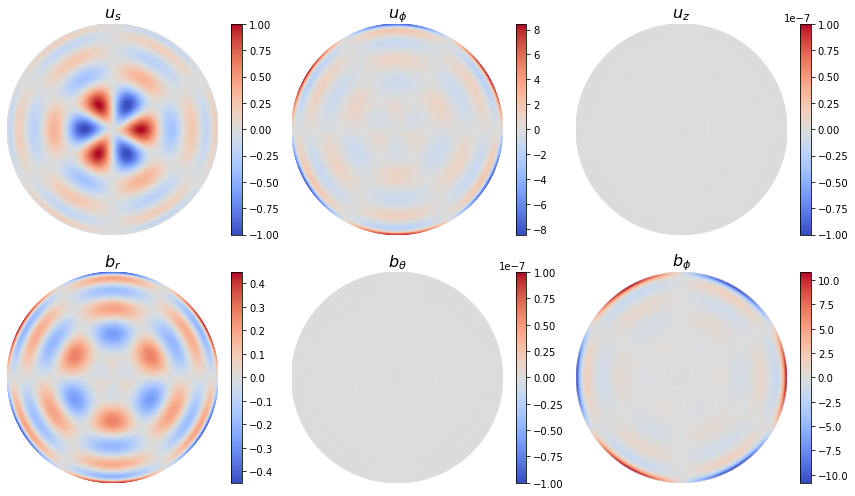

In [234]:
plot_fields = [["u_s", "u_p", "u_z"],
               ["b_r", "b_t", "b_p"],]
plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$"],
               [r"$b_r$", r"$b_\theta$", r"$b_\phi$"],]

# save_name = "./runs/S1pi_Le1e-5_Lu5e+5_m3_parity_oppo/v_eq_m3_{}".format(
#     df_view["Index"][category_idx])
save_name = None
override = False

rotate_us_max = True
force_symmetric_cmap = True

max_u_norm = np.abs(u_cyl['s']).max()
max_b_norm = np.abs(b_sph['r']).max()

fields = {
    'u_r': u_sph['r'], 'u_t': u_sph['theta'],
    'u_s': u_cyl['s'], 'u_p': u_cyl['phi'], 'u_z': u_cyl['z'],
    'b_r': b_sph['r'], 'b_t': b_sph['theta'],
    'b_s': b_cyl['s'], 'b_p': b_cyl['phi'], 'b_z': b_cyl['z'],
}

phi_rotate = 0
if rotate_us_max:
    phi_rotate = phi_grid[np.unravel_index(np.argmax(u_cyl['s']), u_cyl['s'].shape)[0]]

rr, pp = np.meshgrid(uphy_eq.rg, phi_grid - phi_rotate)
X1, X2 = rr*np.cos(pp), rr*np.sin(pp)

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3.5))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = fields[fname]
        if np.abs(np.real(field_plot/max_u_norm)).max() > 1e-7:
            # normalizer = max_u_norm if fname[0] == 'u' else max_b_norm
            normalizer = max_u_norm
            if force_symmetric_cmap:
                climit = np.max(np.abs(field_plot/normalizer))
                # if i_c == 1:
                #     climit = 1.
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X1, X2, field_plot/normalizer, vmin=-1e-7, vmax=+1e-7, shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # ax.axis("equal")
        # ax.grid()
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.axis("off")

# fig.suptitle(r"Idx={:d}    $\lambda=${:.4e}".format(
#     category_idx, eigenvals[category_idx][mode_idx],), fontsize=16)
# fig.suptitle(r"Mode {}    $\lambda=${:.4e}".format(
#     df_view["Index"][category_idx], eigenvals[category_idx][mode_idx],), fontsize=16)
plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.tight_layout()
plt.show()

### Meridional slice

Calculate values on a Meridional slice

In [235]:
# longitude = (11/12)*np.pi
longitude = phi_rotate + (1./7)*np.pi

uphy_md = usp.physical_field(worland_transform, legendre_transform)
bphy_md = bsp.physical_field(worland_transform, legendre_transform)

rr, tt = np.meshgrid(uphy_md.grid['r'], uphy_md.grid['theta'])
X1, X2 = rr*np.sin(tt), rr*np.cos(tt)

u_sph = uphy_md.at_phi(phi=longitude)
u_cyl = {
    's': u_sph['r']*np.sin(tt) + u_sph['theta']*np.cos(tt),
    'phi': u_sph['phi'],
    'z': u_sph['r']*np.cos(tt) - u_sph['theta']*np.sin(tt)
}
b_sph = bphy_md.at_phi(phi=longitude)
b_cyl = {
    's': b_sph['r']*np.sin(tt) + b_sph['theta']*np.cos(tt),
    'phi': b_sph['phi'],
    'z': b_sph['r']*np.cos(tt) - b_sph['theta']*np.sin(tt)
}

Visualisation

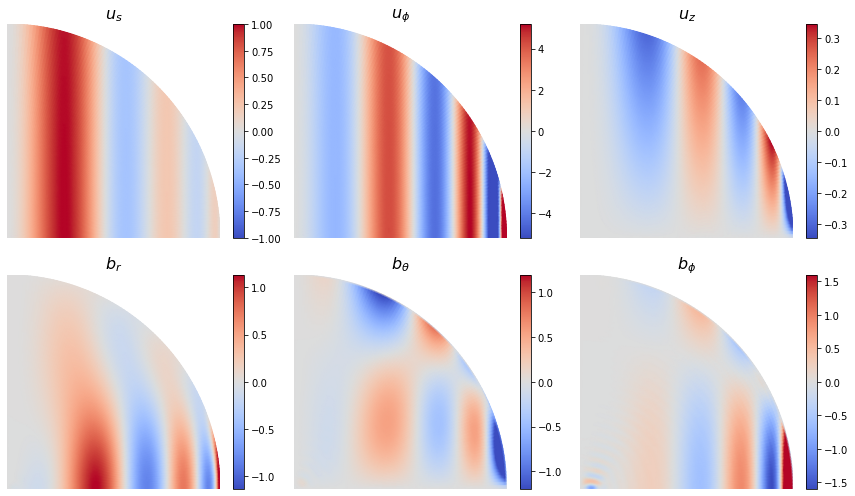

In [236]:
plot_fields = [["u_s", "u_p", "u_z"],
               ["b_r", "b_t", "b_p"],]
plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$"],
               [r"$b_r$", r"$b_\theta$", r"$b_\phi$"],]

# save_name = "./runs/S1pi_Le1e-3_Lu5e+3_m3_parity_oppo/v_md_m3_{:d}".format(category_idx)
# save_name = "./runs/S1pi_Le1e-5_Lu5e+5_m3_parity_oppo/v_md_m3_{}".format(
#     df_view["Index"][category_idx])
save_name = None
override = False

force_symmetric_cmap = True

max_u_norm = np.abs(u_cyl['s']).max()
max_b_norm = np.abs(b_sph['r']).max()

fields = {
    'u_r': u_sph['r'], 'u_t': u_sph['theta'],
    'u_s': u_cyl['s'], 'u_p': u_cyl['phi'], 'u_z': u_cyl['z'],
    'b_r': b_sph['r'], 'b_t': b_sph['theta'],
    'b_s': b_cyl['s'], 'b_p': b_cyl['phi'], 'b_z': b_cyl['z'],
}

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3.5))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = fields[fname]
        if np.abs(np.real(field_plot/max_u_norm)).max() > 1e-7:
            # normalizer = max_u_norm if fname[0] == 'u' else max_b_norm
            normalizer = max_u_norm
            if force_symmetric_cmap:
                climit = np.max(np.abs(field_plot[X1 < 0.9]/normalizer))
                # climit = np.max(np.abs(field_plot/normalizer))
                # climit = 0.2
                # if i_c == 1:
                #     climit = 1.
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X1, X2, field_plot/max_u_norm, vmin=-1e-7, vmax=+1e-7)
            plt.colorbar(cm, ax=ax)
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # ax.axis("equal")
        # ax.grid()
        ax.set_xlim([0, 1])
        # ax.set_ylim([0, 1])
        ax.axis("off")

# fig.suptitle(r"Idx={:d}    $\lambda=${:.4e}".format(
#     category_idx, eigenvals[category_idx][mode_idx],), fontsize=16)
# fig.suptitle(r"Mode {}    $\lambda=${:.4e}".format(
#     df_view["Index"][category_idx], eigenvals[category_idx][mode_idx],), fontsize=16)
plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.tight_layout()
plt.show()

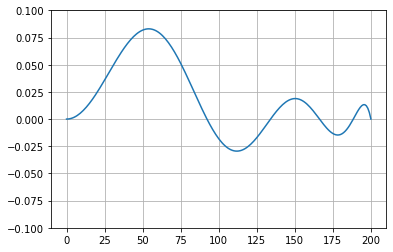

In [239]:
plt.plot(fields['u_s'][-1, :])
plt.grid(which="both")
plt.ylim([-0.1, 0.1])
plt.show()

In [238]:
eigenvals[category_idx][mode_idx]

(-0.001284979347668547-1364.0613752950035j)

---
## Misc. testings

### Reciprocal eigenvalue drift:

In [12]:
w1 = np.array([1., 2., 3., 4., 5., 6., 7., 8.])
w2 = np.array([1.0001, 2.5, 2.6, 2.65, 2.7, 4.0001, 6.6, 7.2, 7.9999, 9.])

tools.print_heading("Testing the reciprocal eigenvalue drift...", suffix='\n', lines="over")
print("w1: {}\nw2: {}\n".format(w1, w2))
print("MCModes utils.reciprocal:\n{}\n".format(utils.reciprocal(w1, w2)))
print("PlesioGeostroPy numerics.utils.eigen_drift:\n{}\n".format(
    1/pgpy_utils.eigen_drift(w1, w2)[0]))

Testing the reciprocal eigenvalue drift...

w1: [1. 2. 3. 4. 5. 6. 7. 8.]
w2: [1.0001 2.5    2.6    2.65   2.7    4.0001 6.6    7.2    7.9999 9.    ]

MCModes utils.reciprocal:
[5.00000000e+03 1.00000000e+00 5.00000000e+00 2.50000000e+04
 2.18750000e+00 3.75000000e+00 5.50055006e+00]

PlesioGeostroPy numerics.utils.eigen_drift:
[1.00000000e+04 2.00000000e+00 3.33333333e+00 1.00000000e+04
 1.00010001e+00 1.66666667e+00 5.00000000e+00 1.00000000e+04]



In [3]:
import sympy as sym

In [4]:
n, l, x = sym.symbols('n l x')

In [8]:
sym.jacobi_poly(2, sym.S.Half, sym.S.Half)

5*_x**2/2 - 5/8

In [4]:
import sympy as sym

In [7]:
Sr = sym.parsing.mathematica.parse_mathematica("1/5 Sqrt[pi/3] r(5 - 3r^2)")
f_Sr = sym.lambdify([sym.Symbol('r'),], Sr, modules=["numpy", "scipy"])

In [11]:
print(f_Sr.__doc__)

Created with lambdify. Signature:

func(r)

Expression:

sqrt(3)*sqrt(pi)*r*(5 - 3*r**2)/15

Source code:

def _lambdifygenerated(r):
    return (1/15)*sqrt(3)*sqrt(pi)*r*(5 - 3*r**2)


Imported modules:




In [13]:
from fields.spectrum import jwt, ijwt

In [14]:
jwt(f_Sr, l=1, nr=10)

array([ 4.98794825e-01, -1.36034952e-01,  2.08166817e-17, -1.04083409e-16,
       -1.80411242e-16, -2.77555756e-16, -3.05311332e-16, -2.74086309e-16,
       -2.32452946e-16, -2.70616862e-16])